In [166]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from itertools import combinations
import statsmodels.api as sm
import time
import itertools
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
###############labs

In [6]:
#Subset Selection Methods

In [7]:
#Forward Selection

In [8]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum() #Salary is missing for 59 players.

#removes all of the rows that have missing values in any variable
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

In [9]:
#choose the best model using forward selection based on Cp

In [10]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [11]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [12]:
#o freeze the frst argument with our estimate of σ2
neg_Cp = partial(nCp, sigma2)

In [13]:
#forward stepwise until any further additions to the model do not result in an improvement in the evaluation score.
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [14]:
# fit a linear regression model with Salary as outcome using forward selection

#Without specifying a scoring argument, the score defaults to MSE, and so all 19 variables will be selected

In [15]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [16]:
#Using neg_Cp results in a smaller model, as expected, with just 10 variables selected
hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [17]:
#Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [18]:
#selects the model at each step based on the biggest reduction in RSS.
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy) #sklearn_selection_path()

In [19]:
#fit the full forward-selection path on the Hitters data and compute the fitted values.
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape
# 20 steps in all, including the fitted mean for the null model — which we can use to evaluate in-sample MSE.

(263, 20)

(50000.0, 250000.0)

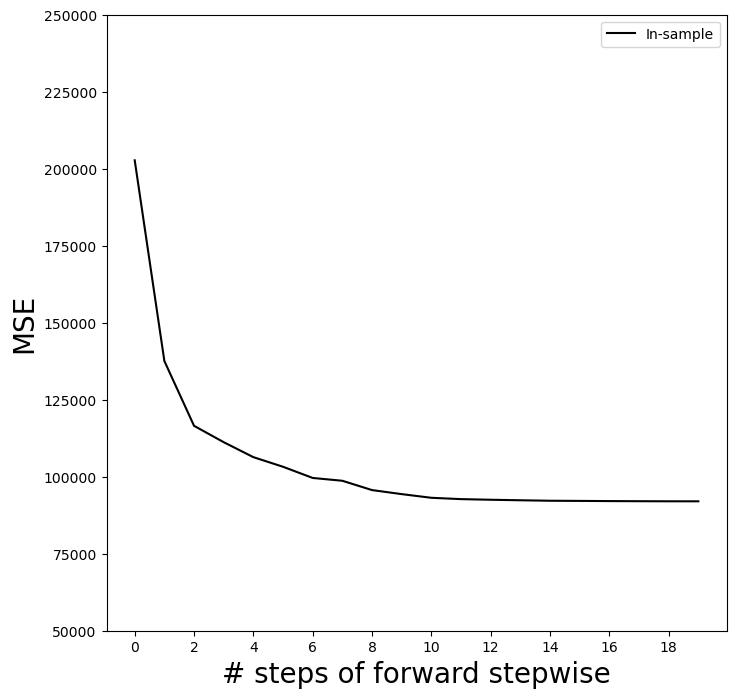

In [20]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0) #Y[:, None] reshapes Y from a 1D array (shape n) into a 2D column vector of shape n×1.
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]) #fix the y-axis to range from 50,000 to 250,000 to compare to the cross-validation and validation set MSE below

In [21]:
#compute the cross-validated predicted values using 5-fold crossvalidation.
K=5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold) #Yhat_cv is the same shape as Yhat_in
Yhat_cv.shape

(263, 20)

In [22]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y): #test indices for each cross-validation split.
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
    
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

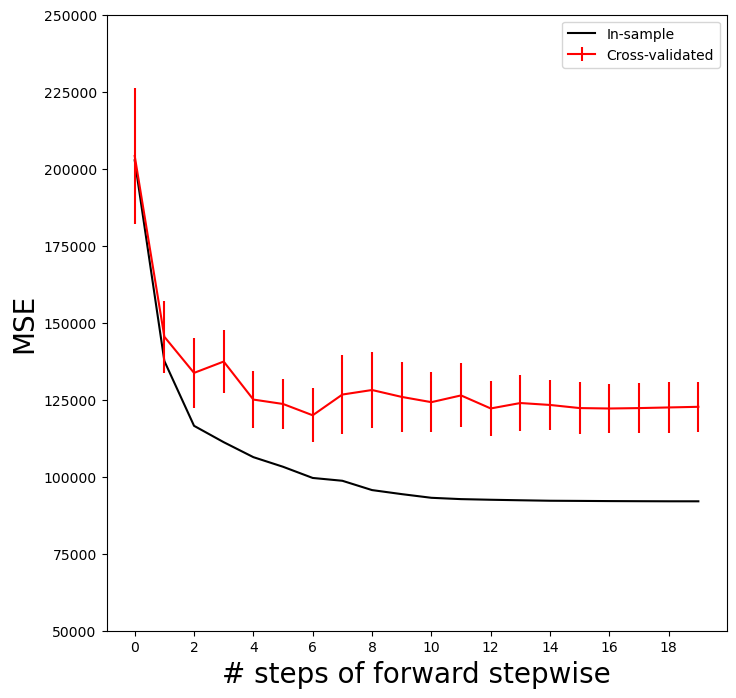

In [23]:
#add the cross-validation error estimates to our MSE plot
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [24]:
#  repeat the above using the validation set approach  simply change cv argument to a validation set
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

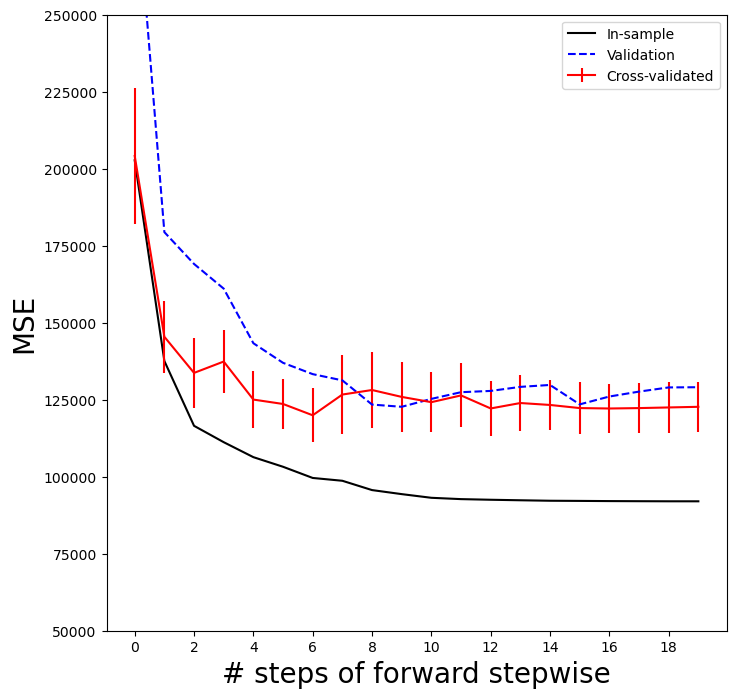

In [25]:
#As for the in-sample MSE case, the validation set approach does not provide standard errors.
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [26]:
#Best Subset Selection
#use a package called l0bnb to perform best subset selection

In [27]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [28]:
#fit the intercept separately
path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [29]:
#fit_path() returns a list whose values include the ftted coefcients as B, an intercept as B0,

In [30]:
path[3]
#at the fourth step in the path, we have two nonzero coefcients in 'B'
#using this sequence of fts on a validation set as a function of lambda_0, or with more work using cross-validation.

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555551,
 'lambda_0': 0.011416248027450178,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

In [31]:
#6.5.2 Ridge Regression and the Lasso

In [32]:
#The parameter λ in (6.5) and (6.7) is called alphas in sklearn

In [33]:
#Ridge Regression


In [34]:
Xs = X - X.mean(0)[None,:] #[None,:] add a dimension
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std() # np.linspace(8, -2, 100) create an array of 100 equally spaced numbers between 8 and −2.

soln_array = skl.ElasticNet.path(Xs, #fits a path along an automatically selected range of λ values
                                 Y,
                                 l1_ratio=0.,#, except for the case when l1_ratio=0,
                                 alphas=lambdas)[1]
soln_array.shape

(19, 100)

In [35]:
#, soln_array is a 19 × 100 matrix, 
#with 19 rows (one for each predictor) and 100 columns (one for each value of λ).

In [36]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path.head(10)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
-11.147933,0.002560,0.002845,0.002225,0.002723,0.002915,0.002879,0.002598,0.003412,0.003560,0.003404,0.003649,0.003677,0.003177,-0.000093,-0.001249,0.001949,0.000165,-0.000035,-0.000018
-10.915349,0.003231,0.003590,0.002807,0.003436,0.003678,0.003632,0.003279,0.004306,0.004492,0.004296,0.004605,0.004640,0.004008,-0.000117,-0.001576,0.002459,0.000208,-0.000044,-0.000023
-10.682765,0.004076,0.004530,0.003542,0.004335,0.004641,0.004583,0.004137,0.005433,0.005668,0.005420,0.005810,0.005854,0.005058,-0.000147,-0.001988,0.003103,0.000263,-0.000056,-0.000029
-10.450180,0.005144,0.005716,0.004469,0.005471,0.005856,0.005783,0.005220,0.006855,0.007152,0.006839,0.007331,0.007387,0.006382,-0.000186,-0.002509,0.003915,0.000331,-0.000070,-0.000037


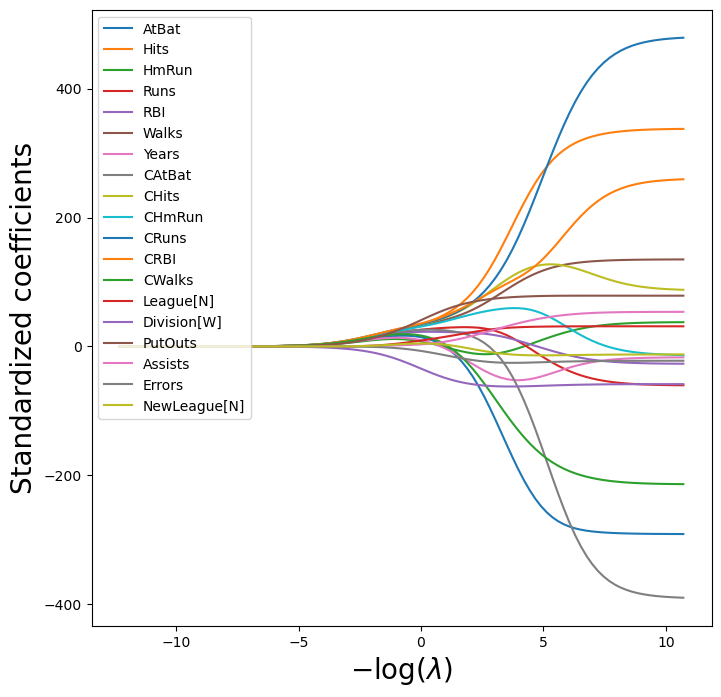

In [37]:
# plot the paths to get a sense of how the coefcients vary with λ
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

In [38]:
#display the coefcients at the 40th step, where λ is 25.535
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [39]:
# compute the  l2 norm of the standardized coefcients.
np.linalg.norm(beta_hat)

24.17061720144378

In [40]:
#l 2 norm when λ is 2.44e-01. Note the much larger l2 norm of the coefcients associated with this smaller value of λ.

In [41]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725839)

In [42]:
# seperate normalization from the ftting of the ridge model itself.
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [43]:
#it gives the same l2 norm as in our previous ft on the standardized data
np.linalg.norm(ridge.coef_)

160.4237101772591

In [44]:
#pipe.fit(X, Y) above has changed the ridge object, 
#and in particular has added attributes such as coef_ that were not there before.

In [45]:
#Estimating Test Error of Ridge Regression

In [46]:
#fix the random state of the splitter so that the results obtained will be reproducibl
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([134214.00419204])

In [47]:
# if we had instead simply ft a model with just an intercept, we would have predicted each test observation using
#the mean of the training observations

In [48]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([231788.32155285])

In [49]:
#first use the validation set method to choose λ.
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [50]:
#K=5
#kfold = skm.KFold(K,
                  #random_state=0,
                  #shuffle=True)
#Yhat_cv = skm.cross_val_predict(full_path,
                                #Hitters,
                                #Y,
                                #cv=kfold)
#Yhat_cv.shape
#the above was set before 
#they will be use in the next  5-fold cross-validation

In [51]:
#can use 5-fold cross-validation
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

In [52]:
#compare R^2 to MSE for cross-validation here

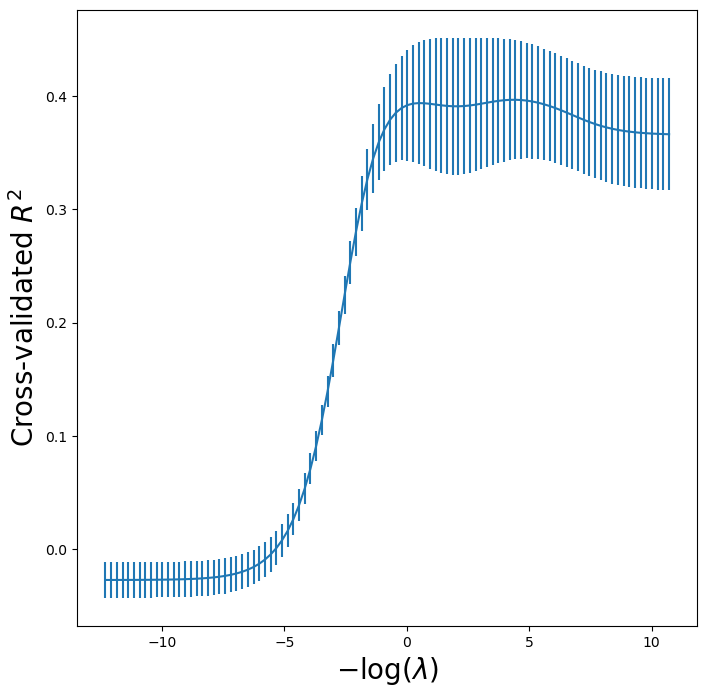

In [53]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)
# plot the results for cross-validated R^2.
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

In [54]:
#Fast Cross-Validation for Solution Paths
#pipeCV

In [55]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

In [56]:
#similar to using skm.GridSearchCV


Text(0, 0.5, 'Cross-validated MSE')

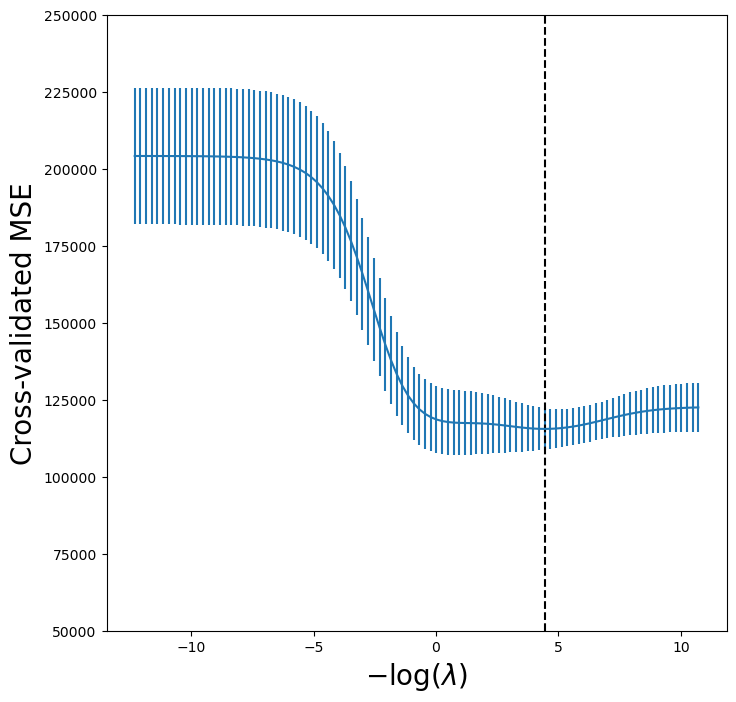

In [57]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [58]:
#We see that the value of λ that results in the smallest cross-validation
#error is 1.19e-02, available as the value tuned_ridge.alpha_. 

In [59]:
np.min(tuned_ridge.mse_path_.mean(1))
#This represents a further improvement over the test MSE that we got using λ = 4.

115526.70630987917

In [60]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

In [61]:
#As expected, none of the coefcients are zero—ridge regression does not perform variable selection!

In [62]:
###############Evaluating Test Error of Cross-Validated Ridge

In [63]:
#use 75% for training and 25% for test, with the estimator being ridge regression tuned using 5-fold cross-validation


In [64]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,##, except for the case when l1_ratio=0
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

In [65]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score'] #MSE

array([132393.84003227])

In [66]:
#################The Lasso

In [67]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1, #change 0 to 1 in lasso
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [68]:
lambdas , soln_array = skl.Lasso.path(Xs,
                                      Y,
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficiients')

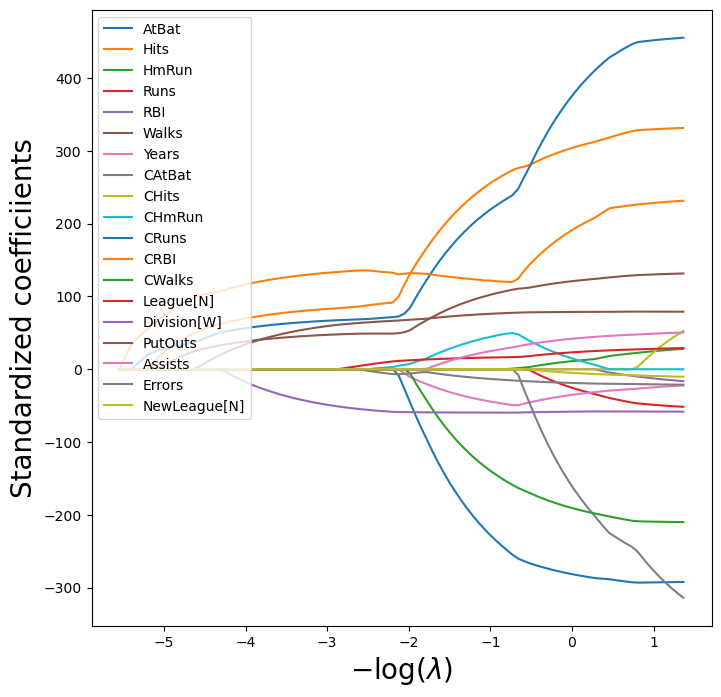

In [69]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

In [70]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253548

In [71]:
#very similar to the test MSE of 115526.71 of ridge regression (page 278) with λ chosen by cross-validation

In [72]:
#produce a plot of the cross-validation error

Text(0, 0.5, 'Cross-validated MSE')

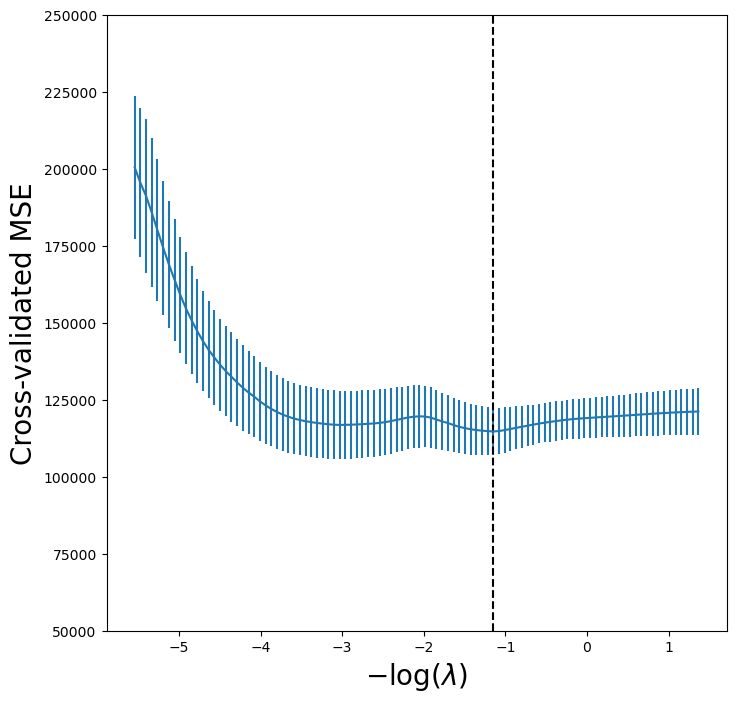

In [73]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [74]:
#Here we see that 6 of the 19 coefcient estimates are exactly zero. So the lasso model with λ chosen
#by cross-validation contains only 13 variables

In [75]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

In [76]:
#########6.5.3 PCR and PLS Regression

In [77]:
#PCR
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [78]:
#results vary depending on whether the data has been standardized or not
pipe = Pipeline([('scaler', scaler),#standardized
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

In [79]:
param_grid = {'pca__n_components': range(1, 20)} #choose the number of components from 1 to 19
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

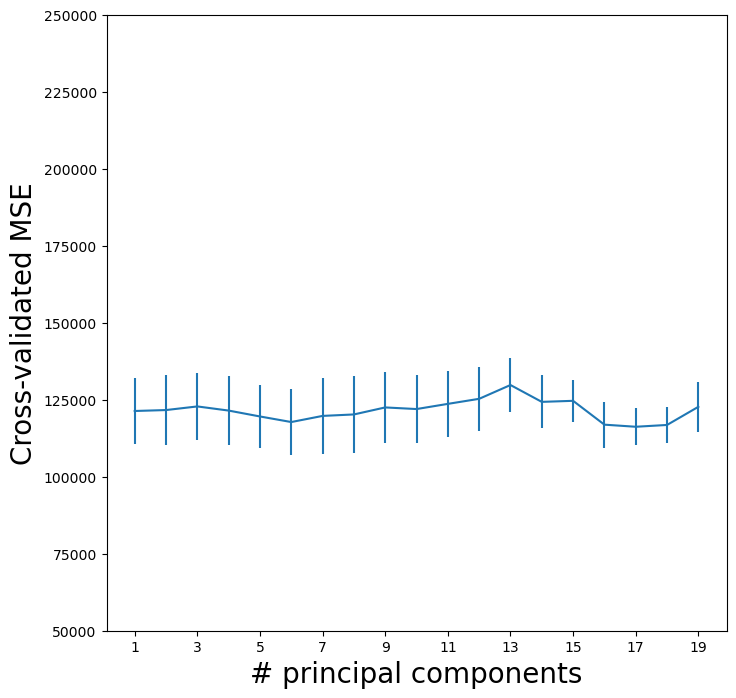

In [80]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])

In [81]:
# smallest cross-validation error occurs when 17 components are used

In [82]:
#PCA() method complains if we try to ft an intercept only with n_components=0
#also compute the MSE for just the null model with these splits

In [83]:
Xn = np.zeros((X.shape[0], 1)) #X.shape[0] refers to the number of rows in the array or matrix X
#np.zeros((X.shape[0], 1)) creates a 2D array (or column vector) with X.shape[0] rows and 1 column, filled with zeros
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

In [84]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

In [85]:
#For example, setting M = 1 only captures 38.31% of the variance, while M = 2 captures an additional 21.84%, 
#for a total of 60.15% of the variance. By M = 6 it increases to 88.63%. 
#Beyond this the increments continue to diminish, until we use all M = p = 19 components, which captures all 100% of the variance

In [86]:
##########Partial Least Squares
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, Y)

PLSRegression()

In [87]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

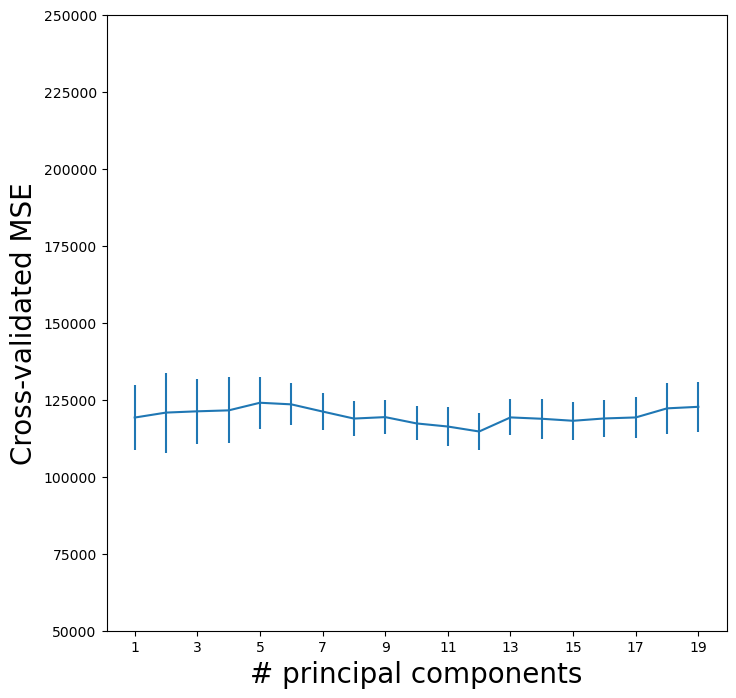

In [88]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])

In [89]:
#CV error is minimized at 12, though there is little noticable diference between this point and a much lower number like 2 or 3 components

In [90]:
#########Applied

In [91]:
#perform forward and backward stepwise selection

In [92]:
#a)
n = 100
rng = np.random.default_rng(66)
X = rng.normal(0, 1, size=n)
eps = rng.normal(0, 1, size=n)

In [93]:
#b) b  constants
b0 = 1
b1 = 2
b2 = 3 
b3 = 4
Y = b0 + b1*X + b2*(X**2) + b3*(X**3) + eps

In [94]:
#c)
#predictors X, X2,...,X10


In [95]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1)) ### X_poly now has columns X, X^2, ..., X^10

In [96]:
X_poly_df = pd.DataFrame(X_poly, columns=[f'X^{i+1}' for i in range(X_poly.shape[1])])
X_poly_df['Y'] = Y

In [97]:
def nCp(sigma2, estimator, X1, Y1):
    "Negative Cp statistic"
    n, p = X1.shape
    Yhat = estimator.predict(X1)
    RSS = np.sum((Y1 - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [98]:
design = MS(X_poly_df.columns.drop('Y')).fit(X_poly_df)
Y1 = np.array(X_poly_df['Y'])
X1 = design.transform(X_poly_df)
sigma2 = OLS(Y1,X1).fit().scale

In [99]:
neg_Cp = partial(nCp, sigma2)

In [100]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [101]:
XY_Cp = sklearn_selected(OLS,
                         strategy,
                         scoring=neg_Cp)
XY_Cp.fit(X_poly_df, Y1)
XY_Cp.selected_state_


('X^1', 'X^2', 'X^3')

In [102]:
selected_terms = XY_Cp.selected_state_
X_selected = X_poly_df[list(selected_terms)]
final_model = OLS(Y1, add_constant(X_selected)).fit()

final_model.params #close to what I set before 
#b0 = 1 b1 = 2 b2 = 3  b3 = 4
#Y = b0 + b1*X + b2*(X**2) + b3*(X**3) + eps

const    0.971452
X^1      1.919149
X^2      2.896448
X^3      4.007835
dtype: float64

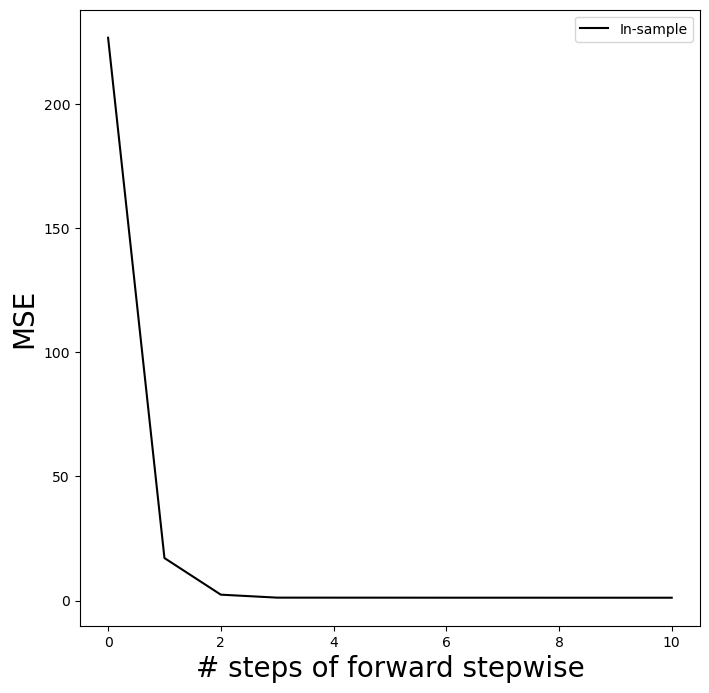

In [103]:
full_path = sklearn_selection_path(OLS, strategy)
full_path.fit(X_poly_df, Y1)
Yhat_in = full_path.predict(X_poly_df)

mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y1[:,None])**2).mean(0) #Y[:, None] reshapes Y from a 1D array (shape n) into a 2D column vector of shape n×1.
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()


In [104]:
# d backwards stepwise selection 
#change the direction in Stepwise.first_peak can't work

In [105]:
# Backward stepwise selection
def backward_stepwise(X, Y):
    terms = list(X.columns) 
    all_models = []  
    rss_values = [] 
    
    # Start with the full model and move backwards
    while len(terms) > 1:
        
        best_rss_step = float('inf')  # Track the best RSS value at this step
        best_terms_step = None  # Track the best set of terms for this step

        for term in terms:
            terms_to_keep = [t for t in terms if t != term]
            X_reduced = X[terms_to_keep]

            model = OLS(Y, add_constant(X_reduced)).fit()
            RSS = np.sum((Y - model.predict(add_constant(X_reduced)))**2)

            if RSS < best_rss_step:  # Use RSS to select best model at this step
                best_rss_step = RSS
                best_terms_step = terms_to_keep
        
        # Store all the 10 best model for this step
        all_models.append(best_terms_step)  # Store all models
        terms = best_terms_step.copy() 

    return all_models, rss_values

# Compute AIC only for the final set of 10 models after backward selection
def compute_aic_for_selected_models(X, Y, models):
    aic_values = []
    for i, terms in enumerate(models):
        X_reduced = X[terms]
        model = OLS(Y, add_constant(X_reduced)).fit()
        AIC = model.aic  # Compute AIC for this model
        aic_values.append(AIC)
    return aic_values

# Run backward stepwise selection
X_selected = X_poly_df.drop(columns='Y')  # Drop Y from predictors
Y_selected = X_poly_df['Y']
selected_models, rss_values = backward_stepwise(X_selected, Y_selected)

# Compute AIC for the 10 models obtained from backward selection
aic_values = compute_aic_for_selected_models(X_selected, Y_selected, selected_models)

# Select the model with the smallest AIC
best_model_index = np.argmin(aic_values)
best_model = selected_models[best_model_index]

# Fit the final model with the selected terms
final_model = OLS(Y_selected, add_constant(X_selected[best_model])).fit()


In [106]:
best_model
final_model.params
#same result with c

const    0.971452
X^1      1.919149
X^2      2.896448
X^3      4.007835
dtype: float64

In [107]:
#fit a lasso model

In [108]:
D = design.fit_transform(X_poly_df)
D = D.drop('intercept', axis=1)
X2 = np.asarray(D)

In [109]:
X1s = X2 - X2.mean(0)[None,:] #[None,:] add a dimension
X1_scale = X2.std(0)
X1s = X1s / X1_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y1.std()

In [110]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1, #change 0 to 1 in lasso
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X2, Y1)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.08285246312543862

In [111]:
lambdas , soln_array = skl.Lasso.path(X1s,
                                      Y1,
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficiients')

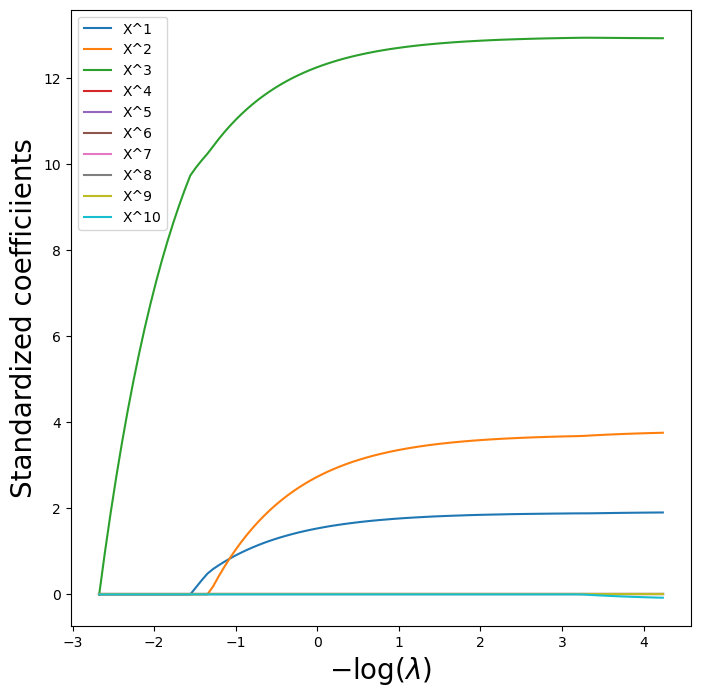

In [112]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

In [113]:
np.min(tuned_lasso.mse_path_.mean(1))

1.2630959944836184

In [114]:
tuned_lasso.coef_

array([ 1.86770249,  3.63811025, 12.90808817,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ])

In [115]:
#same predictors

In [116]:
#Y = β0 + β7X7 + eps

In [117]:
n = 100
rng = np.random.default_rng(66)
X = rng.normal(0, 1, size=n)
eps = rng.normal(0, 1, size=n)
b0 = 1 
b7 = 7
Y = b0 + b7*(X**7) + eps

In [118]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1)) ### X_poly now has columns X, X^2, ..., X^10f
X_poly_df = pd.DataFrame(X_poly, columns=[f'X^{i+1}' for i in range(X_poly.shape[1])])
X_poly_df['Y'] = Y

In [119]:
def nCp(sigma2, estimator, X1, Y1):
    "Negative Cp statistic"
    n, p = X1.shape
    Yhat = estimator.predict(X1)
    RSS = np.sum((Y1 - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [120]:
design = MS(X_poly_df.columns.drop('Y')).fit(X_poly_df)
Y1 = np.array(X_poly_df['Y'])
X1 = design.transform(X_poly_df)
sigma2 = OLS(Y1,X1).fit().scale

In [121]:
neg_Cp = partial(nCp, sigma2)

In [122]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [123]:
XY_Cp = sklearn_selected(OLS,
                         strategy,
                         scoring=neg_Cp)
XY_Cp.fit(X_poly_df, Y1)
XY_Cp.selected_state_

('X^10', 'X^7')

In [124]:
selected_terms = XY_Cp.selected_state_
X_selected = X_poly_df[list(selected_terms)]
final_model = OLS(Y1, add_constant(X_selected)).fit()

final_model.params 

const    0.900562
X^10    -0.000103
X^7      6.999283
dtype: float64

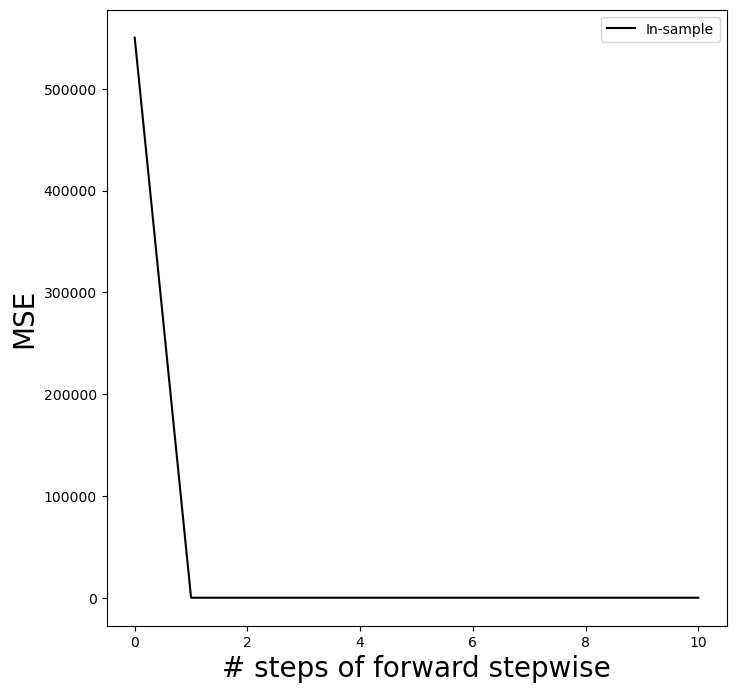

In [125]:
#x^10 was mistakenly included but the coefficient is small
full_path = sklearn_selection_path(OLS, strategy)
full_path.fit(X_poly_df, Y1)
Yhat_in = full_path.predict(X_poly_df)

mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y1[:,None])**2).mean(0) #Y[:, None] reshapes Y from a 1D array (shape n) into a 2D column vector of shape n×1.
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()

In [126]:
D = design.fit_transform(X_poly_df)
D = D.drop('intercept', axis=1)
X2 = np.asarray(D)
X1s = X2 - X2.mean(0)[None,:] #[None,:] add a dimension
X1_scale = X2.std(0)
X1s = X1s / X1_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y1.std()
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1, #change 0 to 1 in lasso
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X2, Y1)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


0.7417287993121489

In [127]:
lambdas , soln_array = skl.Lasso.path(X1s,
                                      Y1,
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficiients')

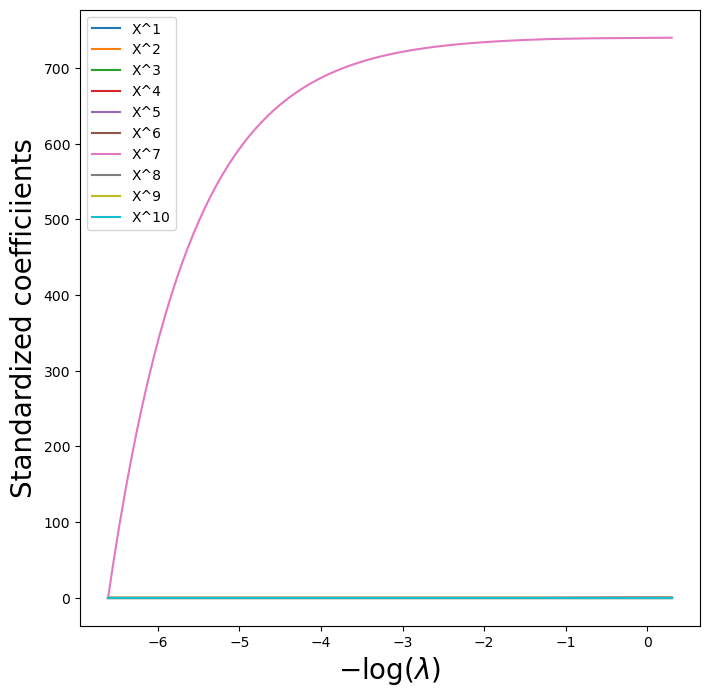

In [128]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

In [129]:
np.min(tuned_lasso.mse_path_.mean(1))

1920.0309333881753

In [130]:
#9
College = load_data('College')
College['Private'] = College['Private'].map({'Yes': 1, 'No': 0})
X = College.drop(columns='Apps') 
y = College['Apps']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=66)

In [131]:
# Fit a linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)

# Calculate MSE
linear_test_mse = mean_squared_error(y_test, y_pred_linear)
linear_test_mse

1163895.326725238

In [132]:
#c
validation = skm.ShuffleSplit(n_splits=1, 
                          test_size=0.5, 
                          random_state=66)

kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
                 
X = College.drop(columns='Apps') 
y = College['Apps']

scaler = StandardScaler()#normalize
lambdas = 10**np.linspace(50, -20, 100) / y.std()

ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)

pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]) 

pipeCV.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.58384481e+46, 5.07219239e+45, 9.95691984e+44, 1.95458384e+44,
       3.83692753e+43, 7.53204471e+42, 1.47857099e+42, 2.90249497e+41,
       5.69771561e+40, 1.11848473e+40, 2.19563100e+39, 4.31011291e+38,
       8.46092684e+37, 1.66091433e+37, 3.26044235e+36, 6.40038087e+35,
       1.25642078e+35, 2.46640507e+34,...
       7.02441011e-11, 1.37892026e-11, 2.70687652e-12, 5.31370864e-13,
       1.04310261e-13, 2.04765282e-14, 4.01962572e-15, 7.89068869e-16,
       1.54897427e-16, 3.04069945e-17, 5.96901662e-18, 1.17174223e-18,
       2.30017762e-19, 4.51534218e-20, 8.86380024e-21, 1.74000002e-21,
       3.41569077e-22, 6.70513983e-23, 1.31624620e-23, 2.58384481e-24]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

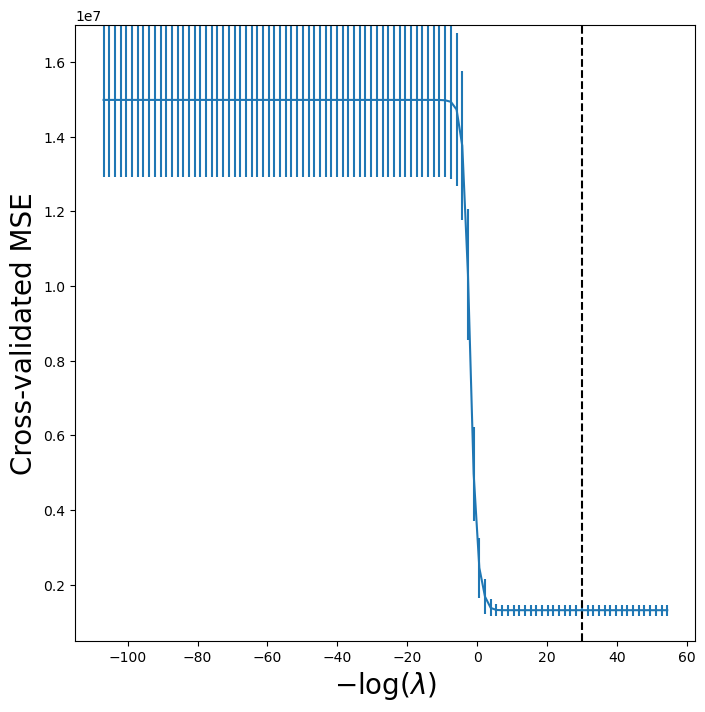

In [133]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([500000, 17000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [134]:
np.min(tuned_ridge.mse_path_.mean(1))

1317720.0427031994

In [135]:
##use 50% for training and 50% for test, with the estimator being ridge regression tuned using 5-fold cross-validation

In [136]:
###############Evaluating Test Error of Cross-Validated Ridge

In [137]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.5,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,##, except for the case when l1_ratio=0
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])

In [138]:
results = skm.cross_validate(pipeCV,
                             X,
                             y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score'] #MSE

array([1467120.36594442])

In [139]:
#d
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1, #change 0 to 1 in lasso
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_ 

25.742927111318053

In [140]:
design = MS(College.columns.drop('Apps')).fit(College)
D = design.fit_transform(College)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

Xs = X - X.mean(0)[None,:] #[None,:] add a dimension
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]

In [141]:
lambdas , soln_array = skl.Lasso.path(Xs,
                                      y,
                                      l1_ratio=1,
                                      n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficiients')

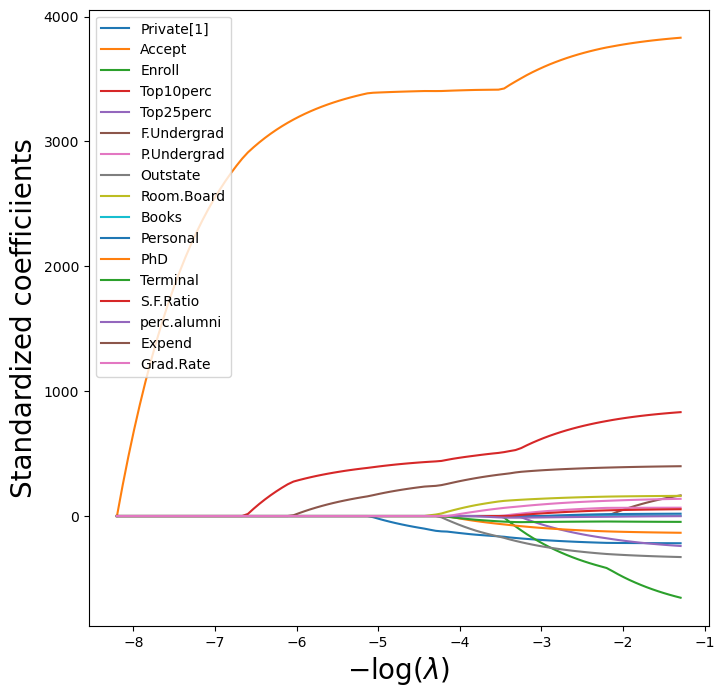

In [142]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

In [143]:
np.min(tuned_lasso.mse_path_.mean(1)) #similar to c)1317720.0427031994

1306504.96312745

In [144]:
#e)PCR
#should standardized 
pca = PCA(n_components=2)
linreg = skl.LinearRegression()

pipe = Pipeline([('scaler', scaler),#standardized
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, y)
pipe.named_steps['linreg'].coef_

array([ 253.66929056, 1558.59994893])

In [145]:
param_grid = {'pca__n_components': range(1, 20)} #choose the number of components from 1 to 19
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

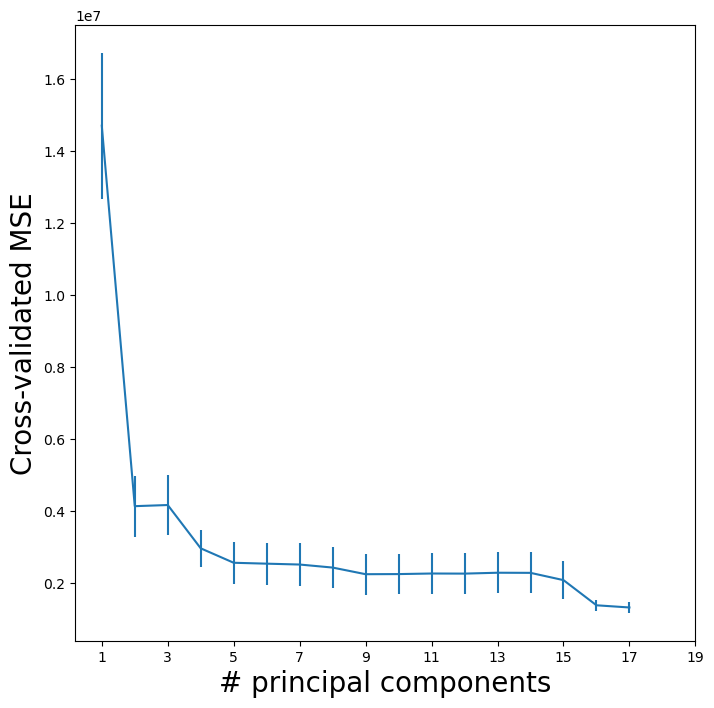

In [146]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])


In [147]:
# smallest cross-validation error occurs when 17 components are used

In [148]:
Xn = np.zeros((X.shape[0], 1)) #X.shape[0] refers to the number of rows in the array or matrix X
#np.zeros((X.shape[0], 1)) creates a 2D array (or column vector) with X.shape[0] rows and 1 column, filled with zeros
cv_null = skm.cross_validate(linreg,
                             Xn,
                             y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

14986195.511757474

In [149]:
#higher than that in c) and d)

In [150]:
#f)Partial Least Squares
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, y)
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
scoring='neg_mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

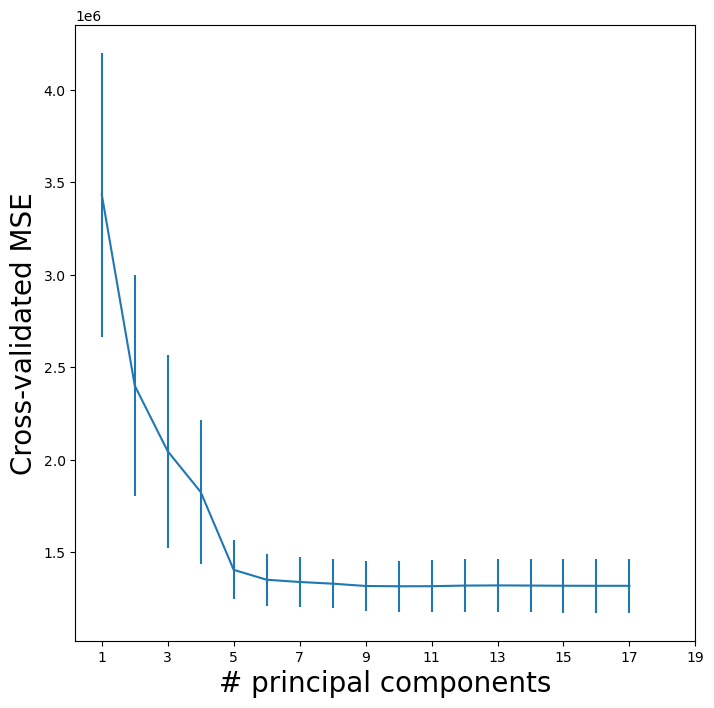

In [151]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [152]:
mean_test_scores = -grid.cv_results_['mean_test_score']
valid_mean_test_scores = mean_test_scores[~np.isnan(mean_test_scores)]
np.min(valid_mean_test_scores)

1315294.9718506793

In [153]:
#there's small difference among the test errors resulting from these five approaches

In [225]:
#10
np.random.seed(66)
n = 1000  # Number of observations
p = 20    # Number of features
X = np.random.normal(0, 1, (n, p))

# Generate the true coefficients β, with some elements set to 0
# Let's set the first 5 elements of β to non-zero values and the rest to 0
beta = np.zeros(p)

non_zero_indices = np.random.choice(p, 5, replace=False)
beta[non_zero_indices] = np.random.uniform(1, 5, 5)

epsilon = np.random.normal(0, 1, n)
Y = np.dot(X,beta) + epsilon


In [155]:
beta

array([3.19602174, 0.        , 1.99513835, 0.        , 0.        ,
       0.        , 0.        , 4.5754622 , 4.32035423, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       3.33171041, 0.        , 0.        , 0.        , 0.        ])

In [156]:
#(b) Split your data set into a training set containing 100 observations and a test set containing 900 observations.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=66)

In [157]:
#(c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.
#fit the intercept separately
path = fit_path(X_train,
                y_train,
                max_nonzeros=X.shape[1])
#returns a list whose values include the fitted coeffucients as B, an intercept as B0,

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  3
Iteration: 3. Number of non-zeros:  4
Iteration: 4. Number of non-zeros:  5
Iteration: 5. Number of non-zeros:  5
Iteration: 6. Number of non-zeros:  5
Iteration: 7. Number of non-zeros:  5
Iteration: 8. Number of non-zeros:  5
Iteration: 9. Number of non-zeros:  5
Iteration: 10. Number of non-zeros:  5
Iteration: 11. Number of non-zeros:  5
Iteration: 12. Number of non-zeros:  6
Iteration: 13. Number of non-zeros:  6
Iteration: 14. Number of non-zeros:  6
Iteration: 15. Number of non-zeros:  6
Iteration: 16. Number of non-zeros:  6
Iteration: 17. Number of non-zeros:  6
Iteration: 18. Number of non-zeros:  6
Iteration: 19. Number of non-zeros:  6
Iteration: 20. Number of non-zeros:  6
Iteration: 21. Number of non-zeros:  6
Iteration: 22. Number of non-zeros:  6
Iteration: 23. Number of non-zeros:  6
Iteration: 24. Number of non-zeros:  6
Iteration: 25. Number of non-zeros:  6
I

In [158]:
path[3]

{'B': array([3.37817674, 0.        , 1.99251609, 0.        , 0.        ,
        0.        , 0.        , 4.39087681, 4.26954481, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.39332132, 0.        , 0.        , 0.        , 0.        ]),
 'B0': 0.04764859557670749,
 'lambda_0': 0.025345669652073754,
 'M': 0.6457122704518247,
 'Time_exceeded': False}

In [159]:
X_train_df = pd.DataFrame(X_train,columns=[f'X{i+1}' for i in range(X_train.shape[1])])
X_train_df['Y'] = y_train

In [160]:
X_train = X_train_df.drop(columns='Y')

In [161]:
def bestSubsets(x,y):
    x_const = sm.add_constant(x)
    model_best = pd.DataFrame(columns=['r_squared','SSE','model'])
    for i in range(1,len(x.columns)+1):
        tic = time.time()
        result = []
        for combo in itertools.combinations(x_const.columns.drop('const'),i):
            
            combo = tuple(['const'])+combo
            regr = sm.OLS(y,x_const[list(combo)]).fit()
            sse = sum(regr.resid ** 2) #sse: sum of squares for errors
            r2 = regr.rsquared
            sub_result = {"model":regr, "SSE":sse, "r_squared":r2}
            result.append(sub_result)
        models = pd.DataFrame(result) 
        best_model = models.loc[models["SSE"].argmin()] 
        
        model_best.loc[i] = best_model
        toc = time.time()
        print("Processed", models.shape[0], "models on", i, "predictors in", (toc-tic), "seconds.")
        
    return model_best


In [162]:
best_model_results = bestSubsets(X_train,y_train)

Processed 20 models on 1 predictors in 0.010190010070800781 seconds.
Processed 190 models on 2 predictors in 0.16334104537963867 seconds.
Processed 1140 models on 3 predictors in 0.4065241813659668 seconds.
Processed 4845 models on 4 predictors in 1.8314192295074463 seconds.
Processed 15504 models on 5 predictors in 6.196966171264648 seconds.
Processed 38760 models on 6 predictors in 15.599481105804443 seconds.
Processed 77520 models on 7 predictors in 32.078444957733154 seconds.
Processed 125970 models on 8 predictors in 65.32469487190247 seconds.
Processed 167960 models on 9 predictors in 98.81730628013611 seconds.
Processed 184756 models on 10 predictors in 147.58664107322693 seconds.
Processed 167960 models on 11 predictors in 114.41753220558167 seconds.
Processed 125970 models on 12 predictors in 89.31155323982239 seconds.
Processed 77520 models on 13 predictors in 60.605947971343994 seconds.
Processed 38760 models on 14 predictors in 27.49894905090332 seconds.
Processed 15504 mod

In [163]:
def compute_aic_for_selected_models(X, Y, selected_models):

    aic_values = []
    best_aic = float('inf')  # Initialize best AIC with infinity
    best_model = None  # Initialize best model
    
    for terms in selected_models:
        X_reduced = X[list(terms)]  # Select the predictors
        model = sm.OLS(Y, add_constant(X_reduced)).fit()  # Fit OLS model
        aic = model.aic  # Compute AIC for the fitted model
        aic_values.append(aic)
        
        # Check if this is the smallest AIC so far
        if aic < best_aic:
            best_aic = aic
            best_model = (terms, model)
    
    return aic_values, best_model


In [210]:
selected_models = best_model_results['model'].apply(lambda m: m.model.exog_names[1:])

aic_for_selected_models, best_model_with_aic = compute_aic_for_selected_models(X_train, y_train, selected_models)

print("AIC values for the selected models:", aic_for_selected_models)
print("Model with the smallest AIC:", best_model_with_aic[0])
print("AIC of the best model:", best_model_with_aic[1].aic)

AIC values for the selected models: [667.5574995084962, 631.1228343913474, 568.0970833151407, 440.70471869392406, 266.6746629714735, 259.31567789372014, 260.27625725598597, 261.0674901814398, 262.3341626846099, 263.8319621636067, 265.2319381387001, 266.70924896478664, 268.27329033107543, 269.997362971466, 271.65054199837823, 273.48021336747354, 275.3451646851799, 277.310937594862, 279.2806168300847, 281.2670233328479]
Model with the smallest AIC: ['X1', 'X3', 'X7', 'X8', 'X9', 'X16']
AIC of the best model: 259.31567789372014


In [211]:
selected_models = selected_models.tolist()

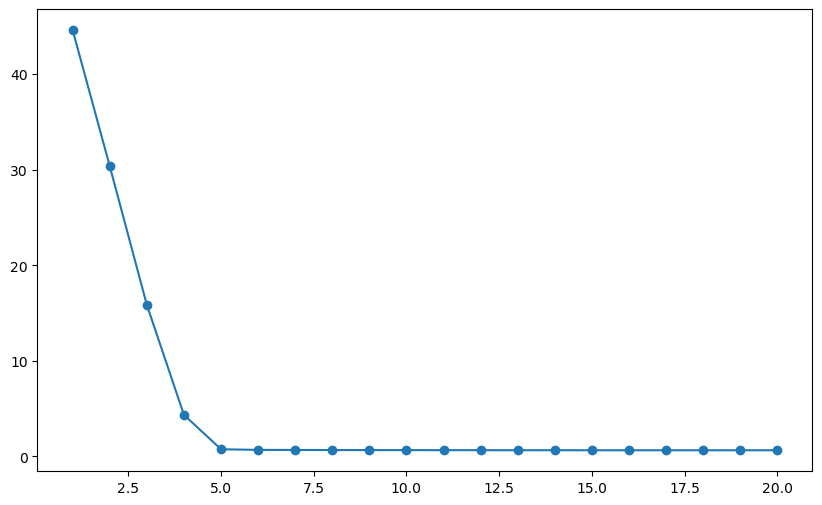

In [215]:
def compute_mse(X, y):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    mse = np.mean(model.resid ** 2)
    return mse

# Calculate MSE for each model
mse_values = []
predictor_counts = []

for model in selected_models:
    X = X_train_df[model]
    y = X_train_df['Y']
    mse = compute_mse(X, y)
    mse_values.append(mse)
    predictor_counts.append(len(model))

plt.figure(figsize=(10, 6))
plt.plot(predictor_counts, mse_values, marker='o')

In [216]:
X_test_df = pd.DataFrame(X_test,columns=[f'X{i+1}' for i in range(X_test.shape[1])])
X_test_df['Y'] = y_test

In [ ]:
X_test = X_test_df.drop(columns='Y')

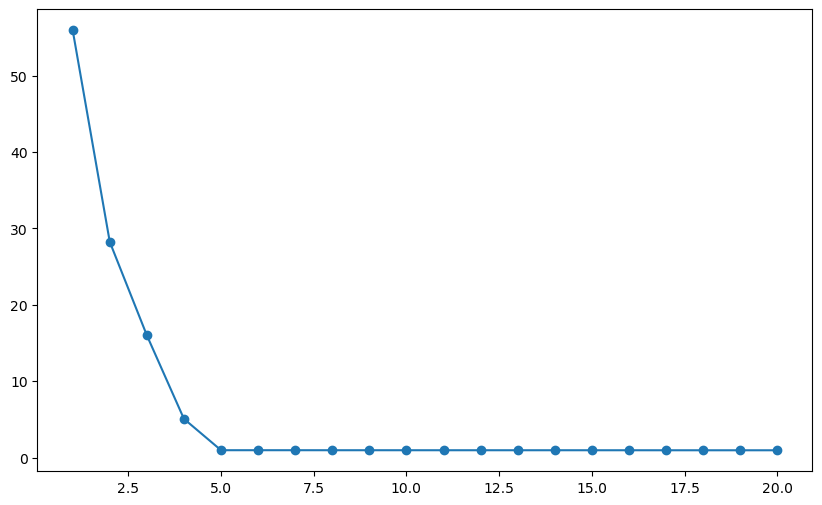

In [217]:
mse_values = []
predictor_counts = []

for model in selected_models:
    X = X_test_df[model]
    y = X_test_df['Y']
    mse = compute_mse(X, y)
    mse_values.append(mse)
    predictor_counts.append(len(model))

plt.figure(figsize=(10, 6))
plt.plot(predictor_counts, mse_values, marker='o')

In [179]:
Boston = load_data('Boston')
design = MS(Boston.columns.drop('crim')).fit(Boston)
D = design.fit_transform(Boston)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
Y = np.array(Boston['crim'])

In [180]:
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([-1.90306309, -0.27286546])

In [181]:
K=10
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
param_grid = {'pca__n_components': range(1, 13)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 13)},
             scoring='neg_mean_squared_error')

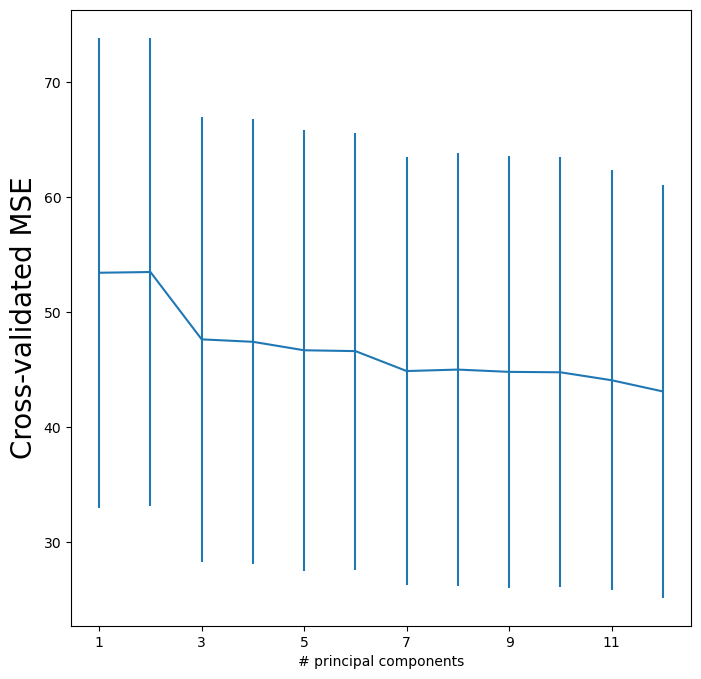

In [183]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2])

In [187]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([ 0.0296096 , -0.01413132])

In [200]:
-grid.cv_results_['mean_test_score']

array([50.89932372, 45.22929818, 44.07837504, 43.77105121, 43.55580684,
       43.25811906, 43.1434348 , 43.11875808, 43.09755761, 43.10765846,
       43.10687228, 43.10670321])

In [188]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')

-cv_null['test_score'].mean()

74.40125520056154

In [189]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.95948975, 0.02752128])

In [193]:
#PLS
pls = PLSRegression(n_components=2,
scale=True)
pls.fit(X, Y)

PLSRegression()

In [198]:
param_grid = {'n_components':range(1, 13)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 13)},
             scoring='neg_mean_squared_error')

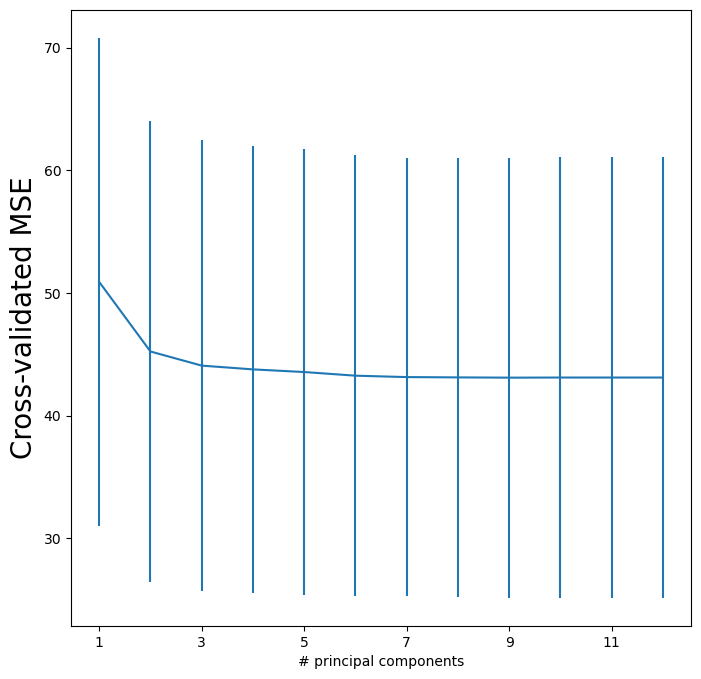

In [199]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2])